# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

The dataset is collected based on 17 marketing campaigns between May 2008 and November 2010 corresponding to a total of 79354 contacts.A subset of this data (cleaned-up) is included in the 'bank-additional-full.csv' file containing a total of 41188 records. During these phone campaigns, the client was offered an attractive long-term deposit application, with good interest rates. A large number of attributes was stored including personal data, bank information, information related to first and last contact, client's familiarity with the product in the home banking site and information from past campaigns. The target variable 'y' was a binary yes/no variable recorded based on whether the client subscribed a long term deposit. There were 4640 clients who subscribed which corresponded to a  11.3% subscription rate.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [17]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, recall_score, precision_score, f1_score, classification_report, plot_confusion_matrix, matthews_corrcoef
from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import seaborn as sns

import category_encoders as ce
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [18]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [19]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



Text(0, 0.5, 'Count')

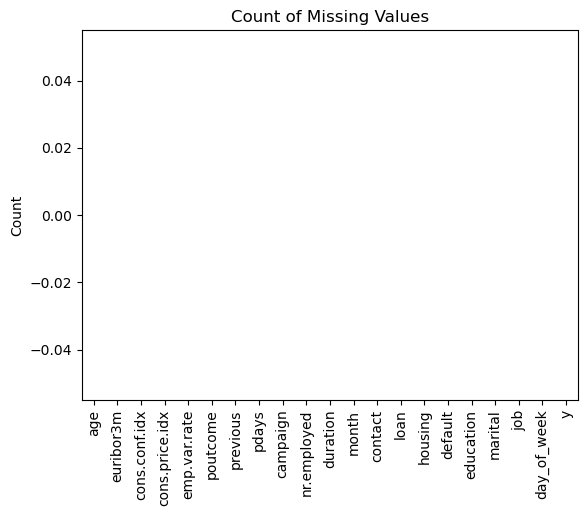

In [20]:
#checking for missing data
ax = df.isnull().sum().sort_values().plot(kind = 'bar', title='Count of Missing Values')
ax.set_ylabel('Count')

In [21]:
#checking for number of entries recorded as 'unknown' in the different categorical features
feat_list = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
number_of_unknowns=[]
for feature in feat_list:
    number_of_unknowns.append(len(df.loc[df[feature] == "unknown"]))
    

df_number_of_unknowns = pd.DataFrame({'Feature': feat_list, 'Number of Unknowns':number_of_unknowns})

df_number_of_unknowns


,Feature,Number of Unknowns
0,job,330
1,marital,80
2,education,1731
3,default,8597
4,housing,990
5,loan,990
6,contact,0
7,month,0
8,day_of_week,0
9,poutcome,0


There does not appear to be any missing data, seems like the dataset had been already cleaned to remove instances of missing data. There are several 'unknown' entries. While this may be considered as a category in itself, in the case of marital status it does not make much sense, hence treating unknown marital status as missing data and dropping those rows seems reasonable

In [22]:
# dropping the martial status which is unknown from our dataframe
df.drop(df[df['marital'] == "unknown"].index, inplace=True)


In [23]:
#checking for duplicate entries and removing them
df.duplicated().sum()

12

In [24]:
# dropping duplicates
df = df.drop_duplicates()

In [25]:
df.shape

(41096, 21)

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41096 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41096 non-null  int64  
 1   job             41096 non-null  object 
 2   marital         41096 non-null  object 
 3   education       41096 non-null  object 
 4   default         41096 non-null  object 
 5   housing         41096 non-null  object 
 6   loan            41096 non-null  object 
 7   contact         41096 non-null  object 
 8   month           41096 non-null  object 
 9   day_of_week     41096 non-null  object 
 10  duration        41096 non-null  int64  
 11  campaign        41096 non-null  int64  
 12  pdays           41096 non-null  int64  
 13  previous        41096 non-null  int64  
 14  poutcome        41096 non-null  object 
 15  emp.var.rate    41096 non-null  float64
 16  cons.price.idx  41096 non-null  float64
 17  cons.conf.idx   41096 non-null 

The **business objective** is to predict which clients subscribed a term deposit. In terms of machine learning this is a ***binary classification task*** where the goal is to classify clients as subscribers or non-subscribers based on the different attributes related to the bank client data.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [27]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41096.000000,41096.000000,41096.000000,41096.000000,41096.000000,41096.000000,41096.000000,41096.000000,41096.000000,41096.000000
mean,40.023311,258.209899,2.566673,962.514186,0.172815,0.082512,93.575923,-40.502246,3.621894,5167.053638
std,10.420089,259.245306,2.767906,186.816397,0.494837,1.570683,0.578727,4.627021,1.734266,72.255185
min,17.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.000000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.000000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.000000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


(41096, 7)

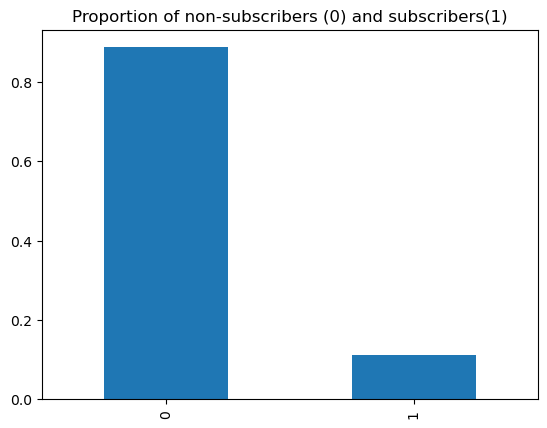

In [28]:
X = df[df.columns[0:7]]
y = df['y'].map({'no': 0, 'yes': 1})

y.value_counts(normalize=True).plot(kind='bar', title='Proportion of non-subscribers (0) and subscribers(1)')
y.value_counts( normalize=True)
X.shape

We notice that there is substantial imbalance in the data with the subscribers being only 11.2% of the customers. We need to address the imbalance by Synthetic  Minority Oversampling Technique (SMOTE) as many classifiers including logistic regression, KNN, SVM, etc does not train well when there is such imbalance. The oversampling will be applied to training data only, so this will be done after train/test split. We also note that some of the categorical features (e.g. job) have a high degree of cardinality, so we will employ target based encoding for these as one hot or similar form of encoding will greatly enhance the number of features. We choose Leave One Out encoding which is a form of target encoding that minimizes bias. In this method, the train and test data are encoded separately - the test data is encoded without utilizing the test values of the target variable which is important for not introducing bias in our encoding method. Hence these two steps (SMOTE and Leave One Out Encoding) are performed after the train/test split

### Exploratory Analysis
As part of our data understanding and preparation, we also perform some exploratory analysis as below, with the specific objective of looking at how individual features vary by target variable

[Text(0.5, 1.0, 'Distribution of Age of Term Subscribers and Non-Subscribers')]

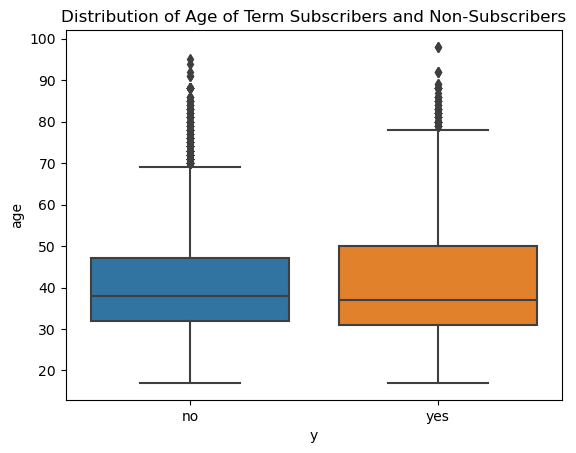

In [29]:
ax = sns.boxplot(x = 'y', y = 'age', data = df)

ax.set(title='Distribution of Age of Term Subscribers and Non-Subscribers')

Age does not seem to be a differentiating feature for subscriber vs no subscriber

Next, we explore barplots of different categorical features grouped by the two classes of  subscribers and non-subscribers

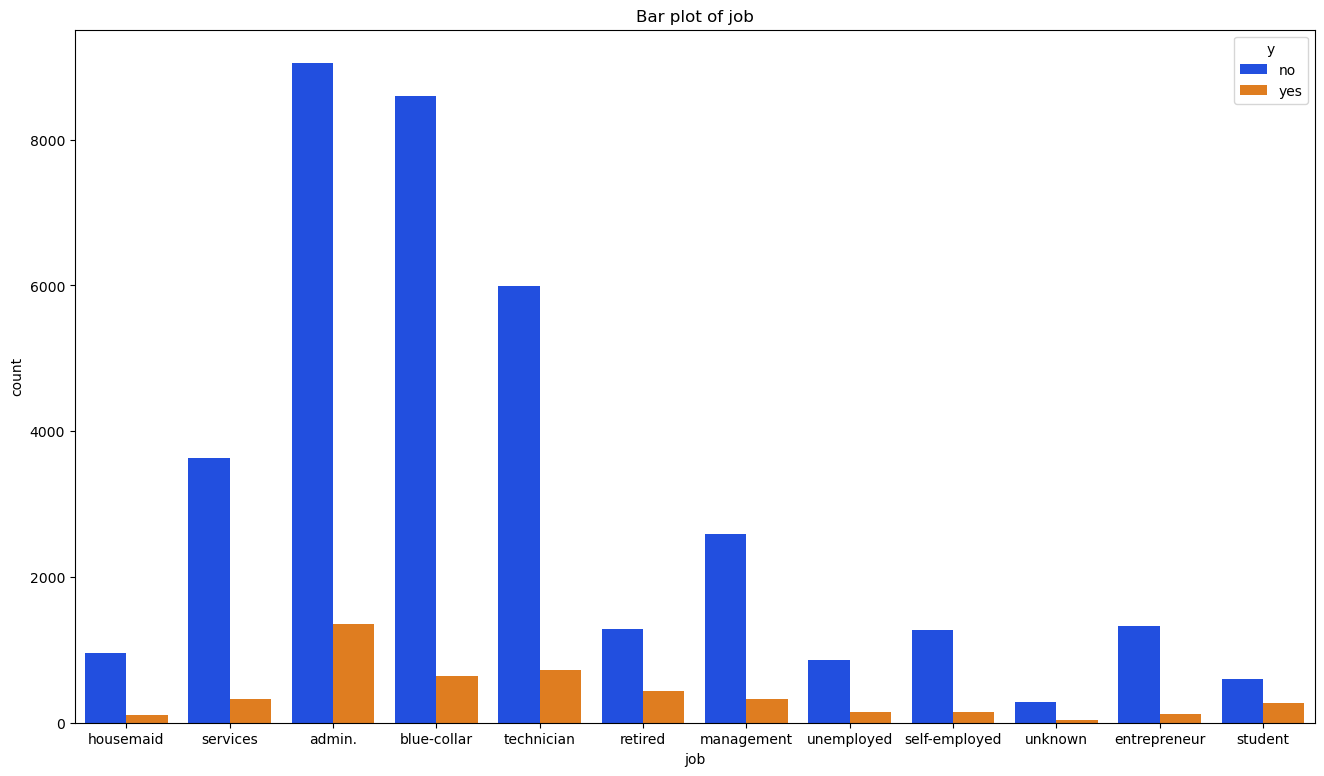

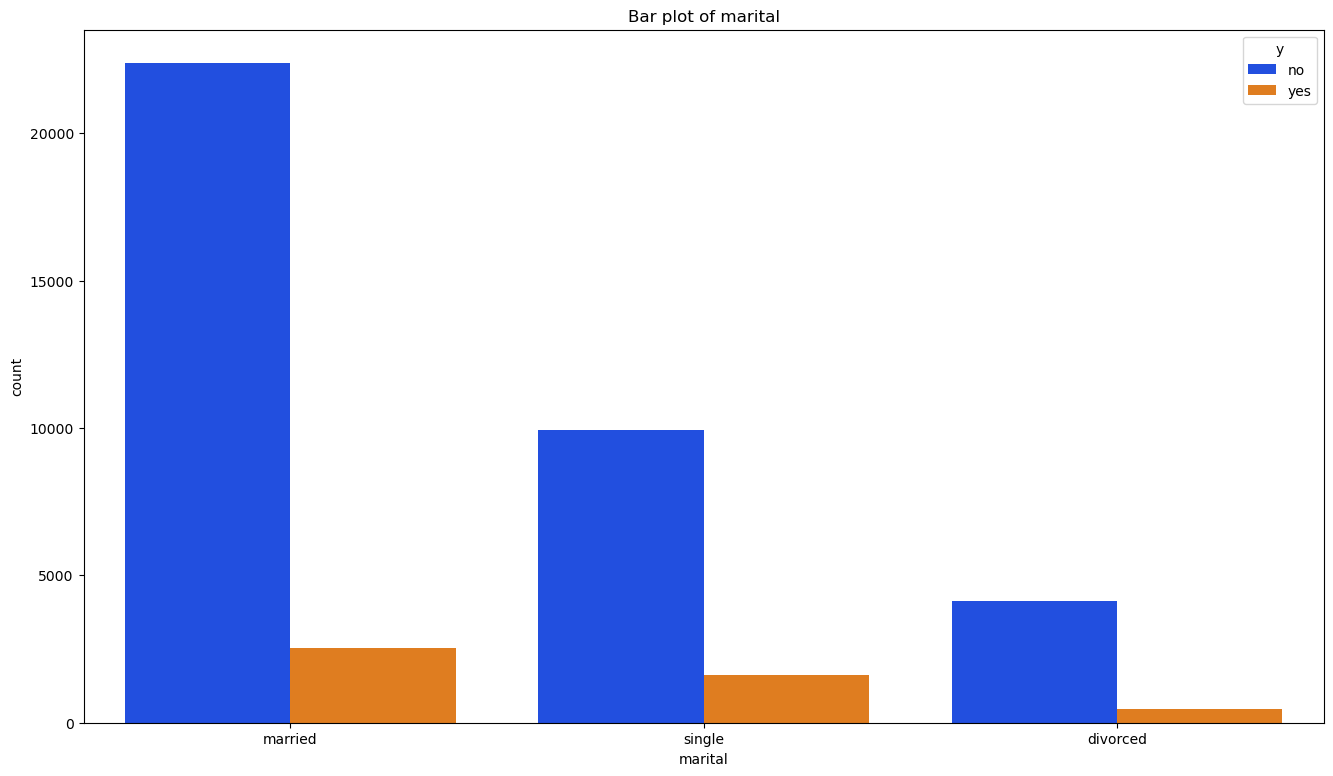

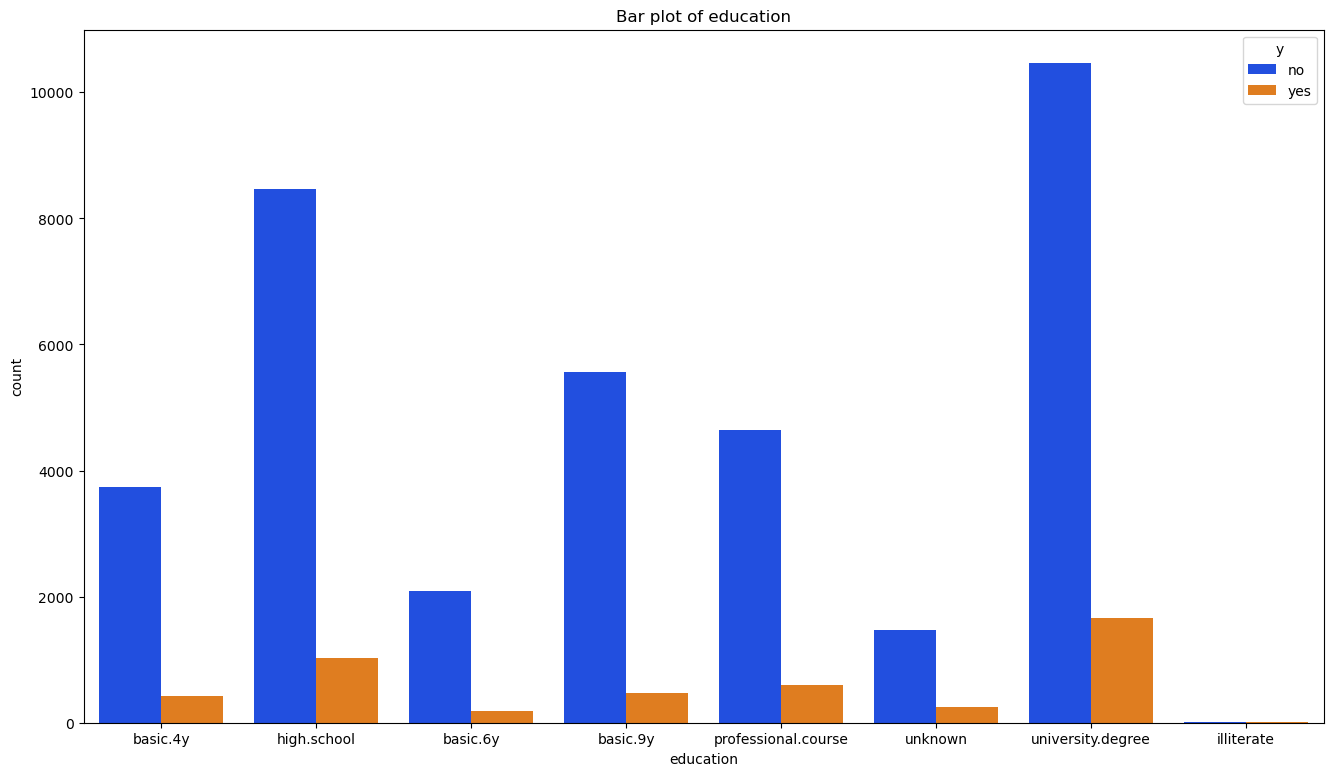

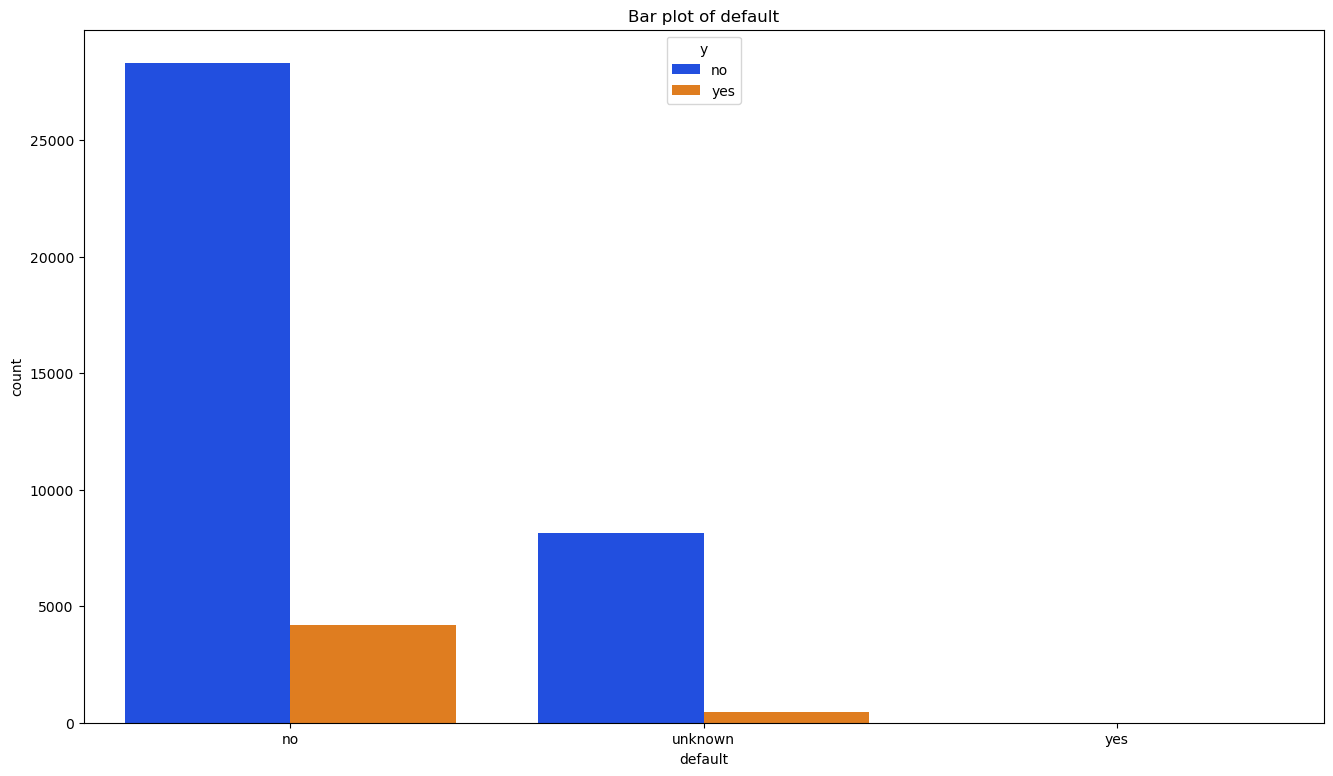

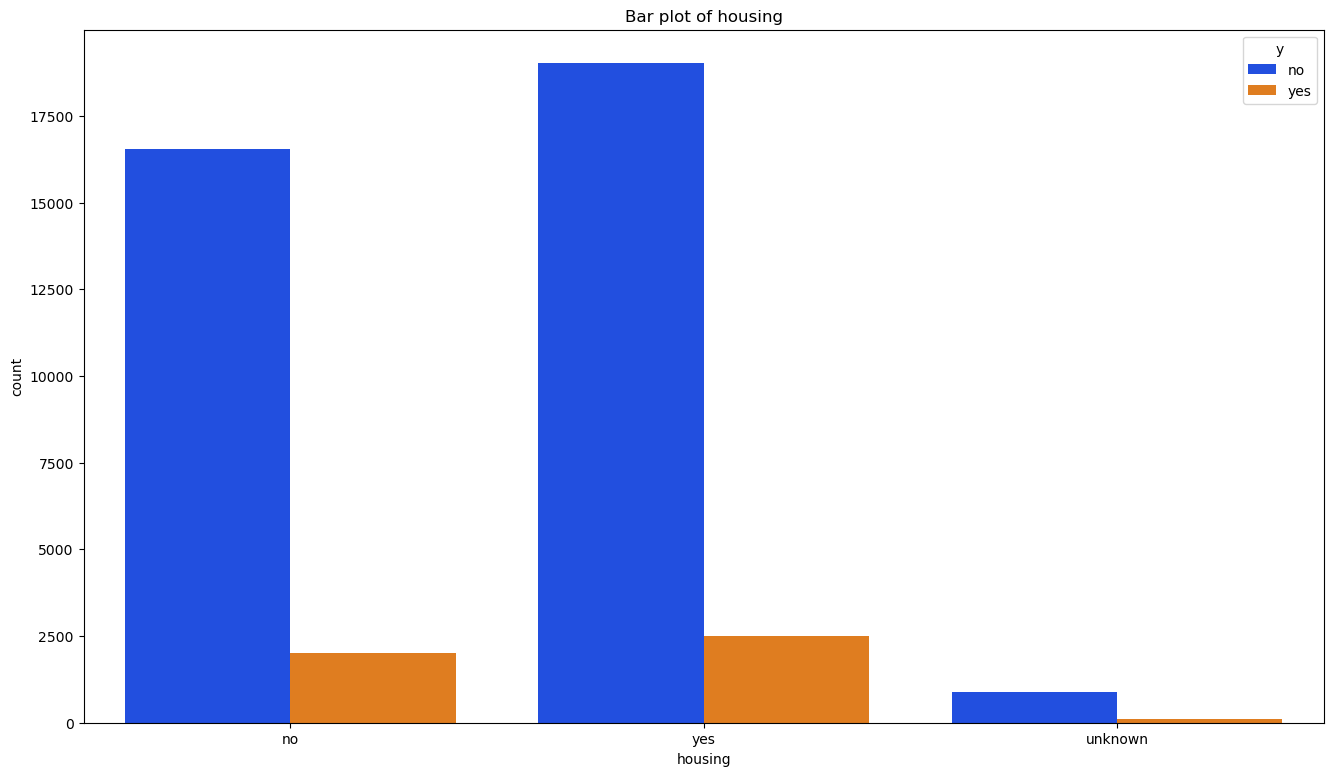

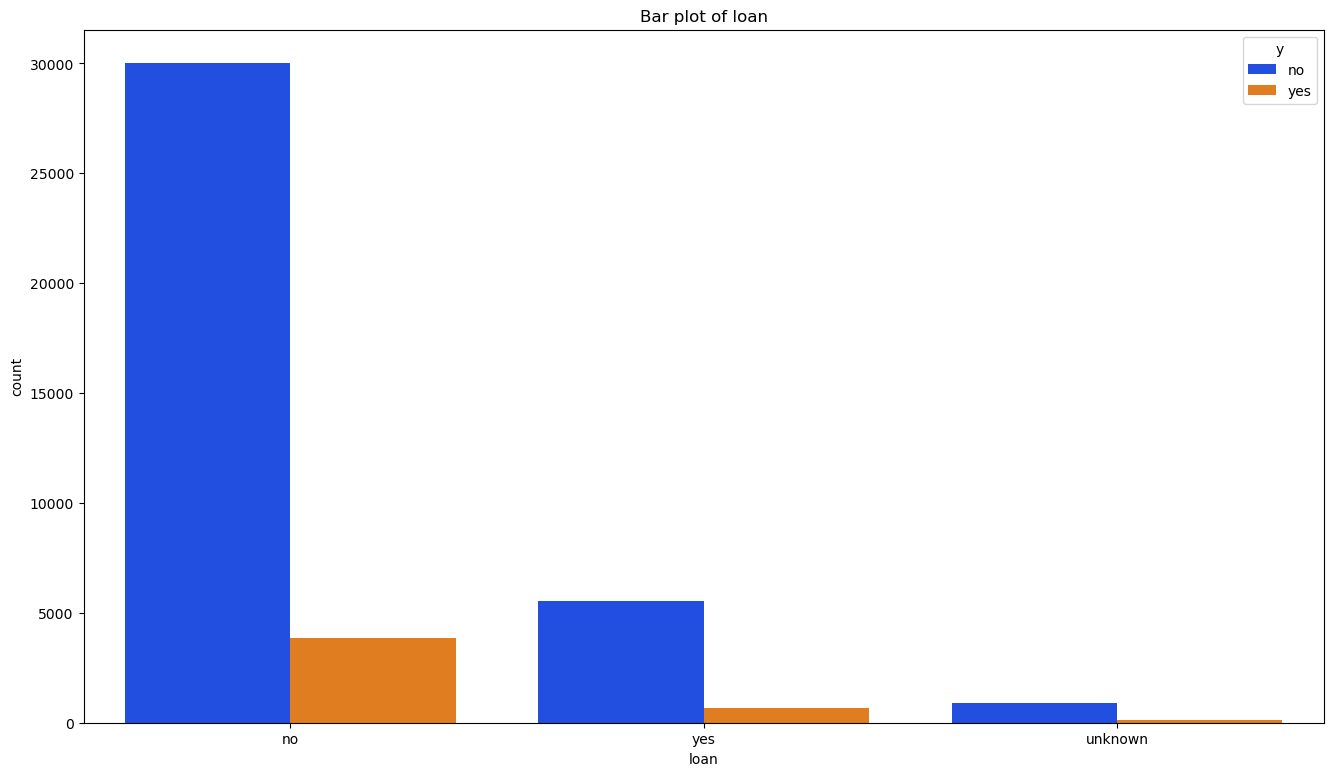

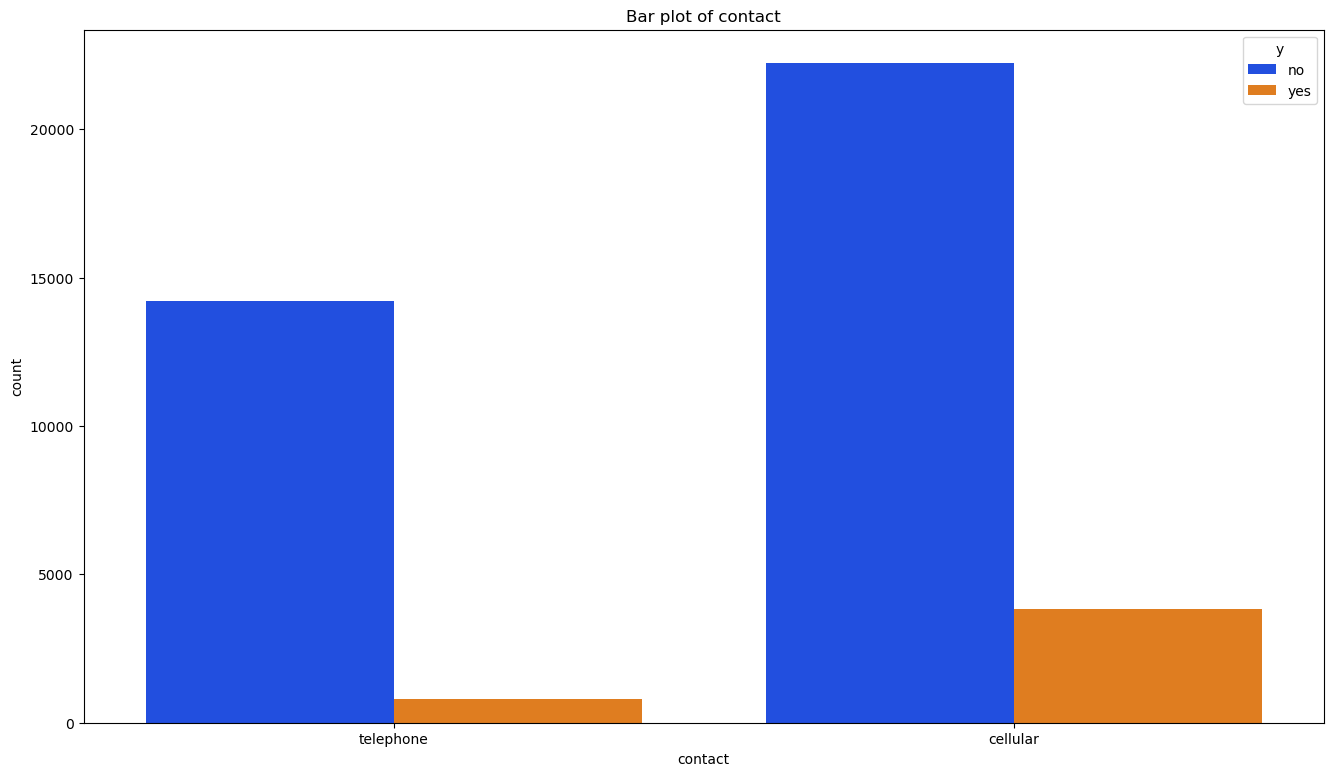

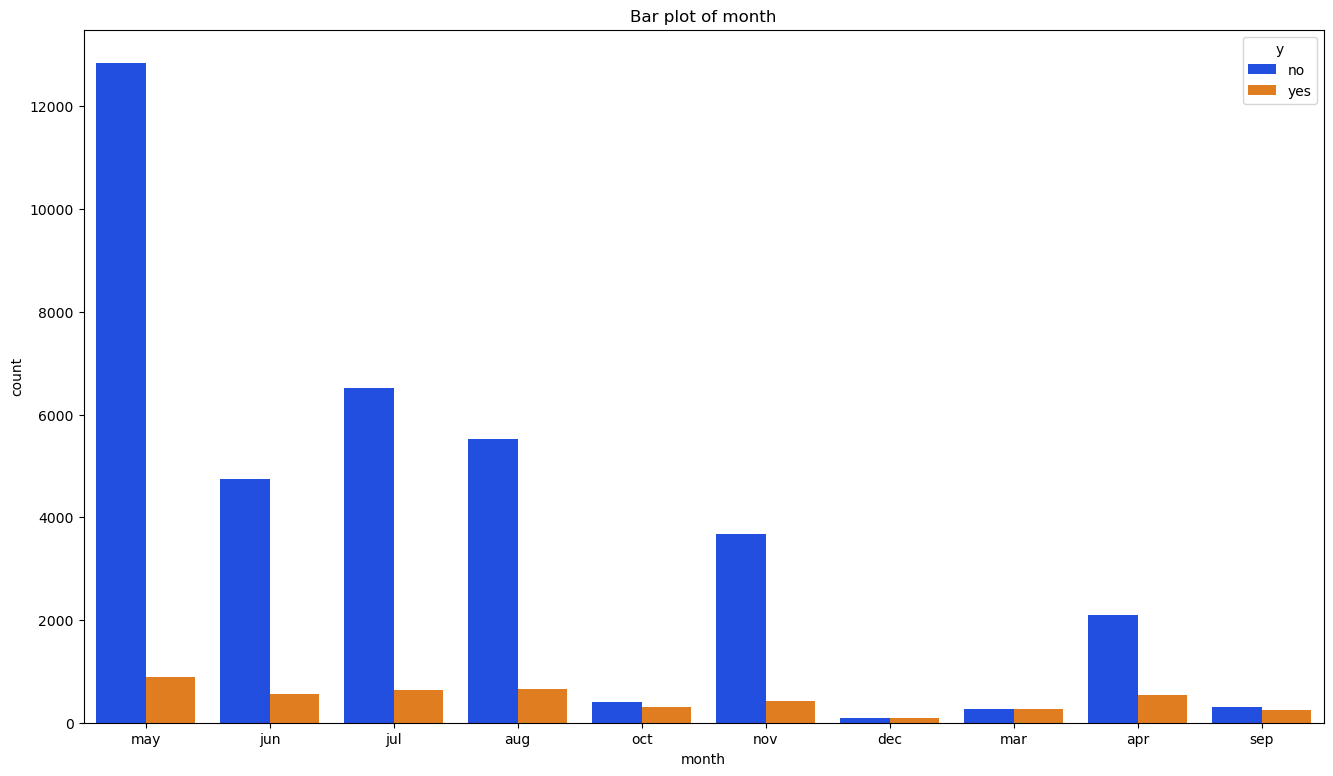

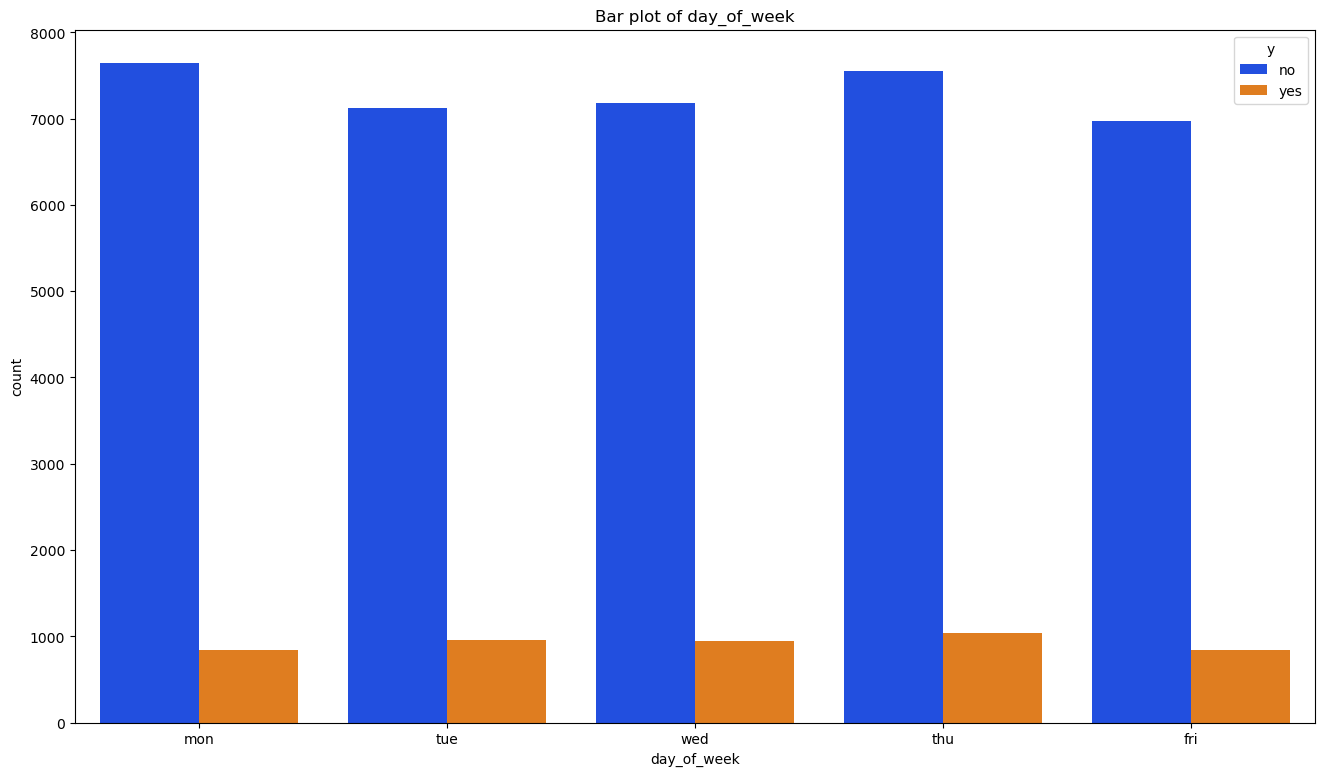

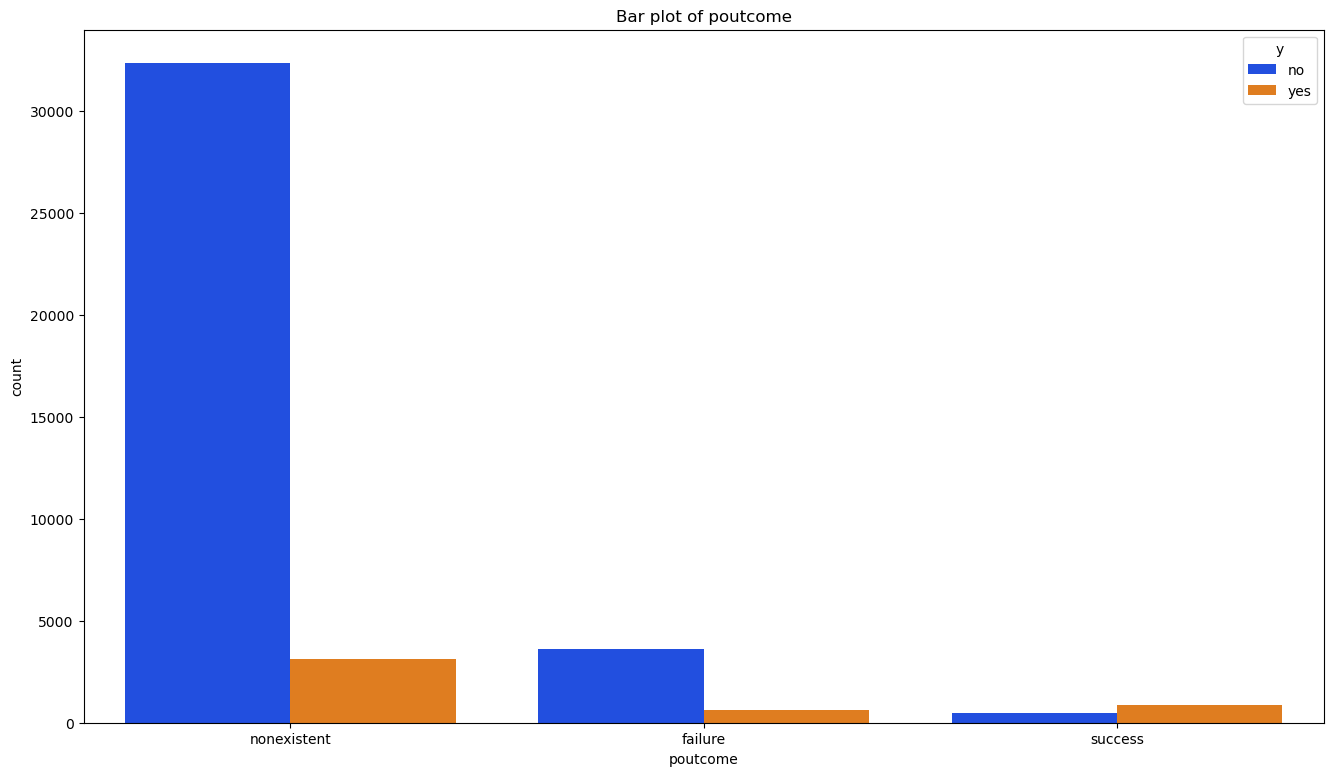

In [30]:
feat_list = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']
for feature in feat_list:
    plt.figure(figsize=(16,9))
    sns.countplot(x = feature, data = df, hue = 'y', palette = 'bright')
    plt.title('Bar plot of '+feature)
    plt.show()


The exploratory data analysis offers some interesting insights:

1) The type of job seems to have some influence on client's decision to subscribe to term deposit: those in 'admin' jobs had the highest count of subscription.

2) Marital status has also influence on subscription with married people most likely to subscribe, followed by single. Divorced clients are least likely to subscribe.

3) Counts of subscribers seem to be somewhat modulated by the level of education: clients with university degree have the highest count of subscription.

4) Default has definitely an influence on subscription: those without credit default have much higher count of subscription than those whose default status is positive or 'unknown'.

5) Housing: Those who responded 'Yes' to the housing question had roughly the same number of term subscribers as those who responded 'No'. Those who had responded 'unknown' to this had the least chance of subscribing term deposit.

6) Loan also appears to have substantial influence on decision to subscribe: those without an existing loan seem to have a higher count of subscription than those who had an existing loan status or those whose existing loan status was unknown.

7) Type of contact seems to matter: those who were contacted on cell phone seem to have a higher subscription count than those contacted via telephone.

8) Day/Month of Contact: The count of subscribers seem to be pretty uniform across the different days of week but certain months of the year, esp May through August were associated with higher counts of subscribers.

9) Outcomes from previous campaigns had a big influence: failure in previous campaigns was associated with least count of subscribers.

#### Exploring the effect of attributes with social/economic context
It is expected that some of these (e.g. interest rates) will affect client's decision to subscribe term deposits. These variables are therefore explored to see how they impact subscription.

[Text(0.5, 1.0, 'Effect of Euribor3m (3 month rates) on Term Subscription')]

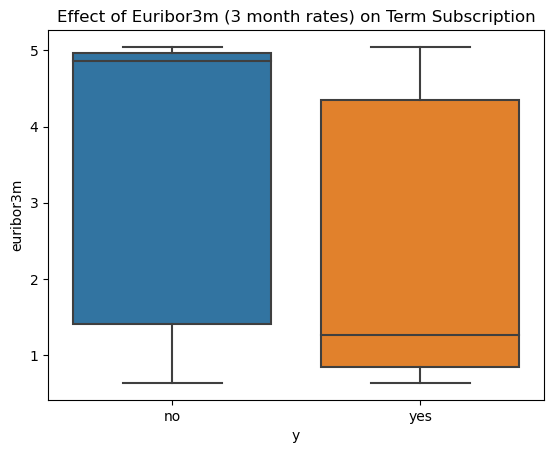

In [31]:
ax = sns.boxplot(x = 'y', y = 'euribor3m', data = df)

ax.set(title='Effect of Euribor3m (3 month rates) on Term Subscription')

This seems to make sense: the decision to subscribe long term deposits is associated with a lower short term rate. When short term rates are high, clients will be less likely to subscribe term deposits which are usually over much longer periods

[Text(0.5, 1.0, 'Effect of Consumer Price Index on Term Subscription')]

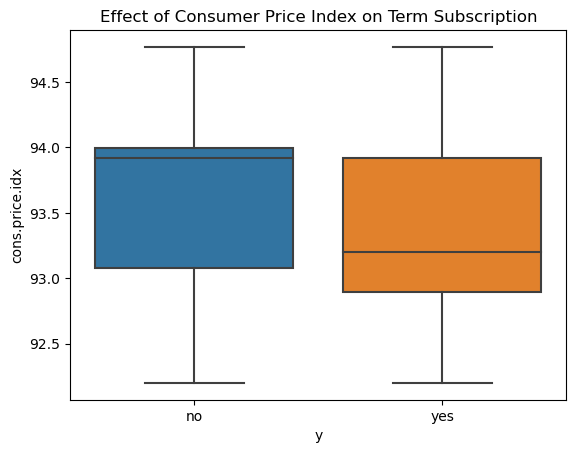

In [32]:
ax = sns.boxplot(x = 'y', y = 'cons.price.idx', data = df)

ax.set(title='Effect of Consumer Price Index on Term Subscription')

[Text(0.5, 1.0, 'Effect of Consumer Confidence Index on Term Subscription')]

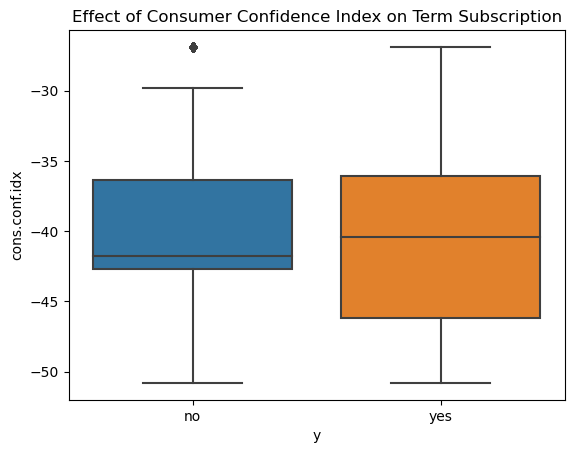

In [33]:
ax = sns.boxplot(x = 'y', y = 'cons.conf.idx', data = df)

ax.set(title='Effect of Consumer Confidence Index on Term Subscription')

Two more interesting insights are obtained from the above boxplots:

1) Decision to sign up for term deposits are affected by consumer price index (CPI): a lower CPI seems to be associated with  term subscription

2) Cosumer confidence index also influences decision to subscribe term deposits: a higher consumer confidence index is favorable for term subscription

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [204]:
#train test split
X_tr, X_te, y_train, y_test = train_test_split(X, y, random_state = 42)

#Encode categorical features using Leave One out Encoding: The Encoding for test data is done without using test values of target variable
encoder = ce.LeaveOneOutEncoder(return_df=True)

#X_train is the training dataset after leave one out encoder has been applied to categorical features
X_train = encoder.fit_transform(X_tr, y_train)

# the test set is encoded without utilizing values of y_test
X_test = encoder.transform(X_te)

After encoding we evaluate correlation matrix to see if there are correlated features in the input data - too many correlated features are best avoided as they lead to multi-collinearity which is not desirable, especially for classifiers like Logistic Regression

<AxesSubplot:>

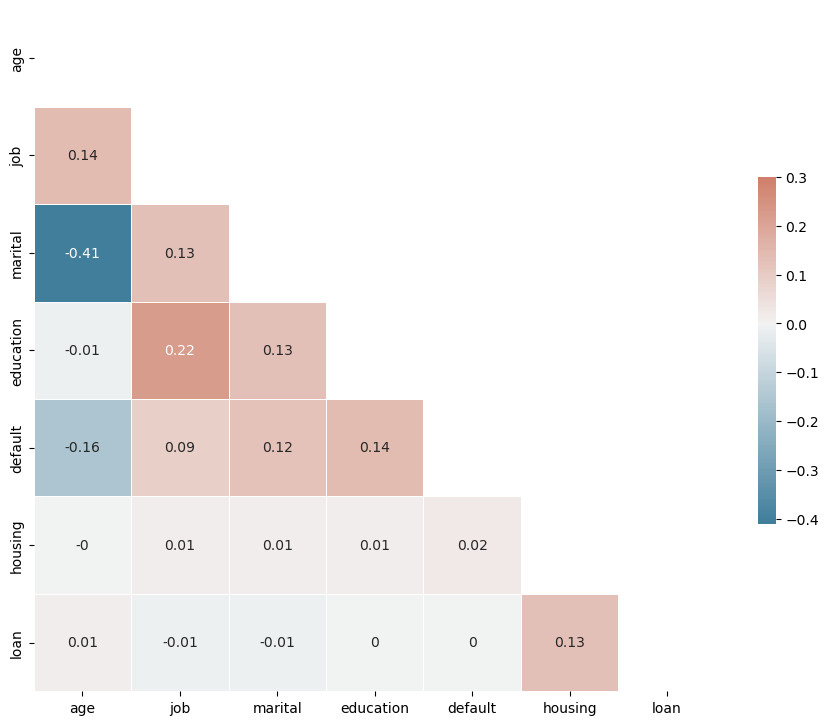

In [205]:
# Compute the correlation matrix
corr = np.around(X_train.corr(),2)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

There is little to no correlation between the input features which is great for classifiers like Logistic Regression. The next step is scaling of features using StandardScaler

In [206]:
#Scale
X_train=StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [207]:
# Address class imbalance through minority oversampling

from imblearn.over_sampling import SMOTE



sm = SMOTE(random_state = 2)
X_train_ovs, y_train_ovs = sm.fit_resample(X_train, y_train.ravel())


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

Training Scores

Train Accuracy for Dummy classifier: 0.5
Train F1 score for Dummy classifer: 0.0
Train Recall for Dummy classifier: 0.0
---------------------------------------------------------------------------------------
Test Scores

Accuracy for a dummy classifier: 0.89
F1 score for a dummy classifier: 0.0
Recall for a dummy classifer: 0.0
---------------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      9112
           1       0.00      0.00      0.00      1162

    accuracy                           0.89     10274
   macro avg       0.44      0.50      0.47     10274
weighted avg       0.79      0.89      0.83     10274

---------------------------------------------------------------------------------------


C:\Users\subha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\subha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\subha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


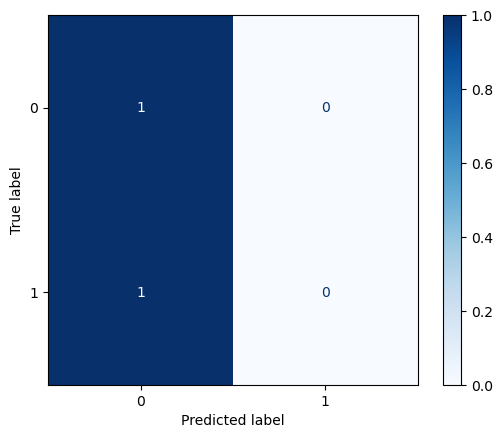

In [208]:
# establish a baseline with a dummy classifier
from sklearn.dummy import DummyClassifier

clf_dummy = DummyClassifier(random_state=42) 
#establishing random_state for reproducibility
start_time=time.time()
clf_dummy.fit(X_train_ovs, y_train_ovs)
end_time=time.time()

fit_time_dummy= end_time - start_time


train_accuracy_dummy = accuracy_score(y_train_ovs, clf_dummy.predict(X_train_ovs))

train_fscore_dummy = f1_score(y_train_ovs, clf_dummy.predict(X_train_ovs))

train_recall_dummy = recall_score(y_train_ovs, clf_dummy.predict(X_train_ovs))


print('Training Scores\n')

print('Train Accuracy for Dummy classifier:', np.around(train_accuracy_dummy,2))
print('Train F1 score for Dummy classifer:', np.around(train_fscore_dummy,2))
print('Train Recall for Dummy classifier:', np.around(train_recall_dummy,2))
print('---------------------------------------------------------------------------------------')



y_pred_dummy = clf_dummy.predict(X_test)

accuracy_dummy = accuracy_score(y_test, y_pred_dummy)

fscore_dummy = f1_score(y_test, y_pred_dummy)

recall_dummy = recall_score(y_test, y_pred_dummy)

print('Test Scores\n')

print('Accuracy for a dummy classifier:', np.around(accuracy_dummy,2))
print('F1 score for a dummy classifier:', np.around(fscore_dummy,2))
print('Recall for a dummy classifer:', np.around(recall_dummy,2))
print('---------------------------------------------------------------------------------------')
print('Classification Report\n')

print(classification_report(y_test, y_pred_dummy))
print('---------------------------------------------------------------------------------------')

plot_confusion_matrix(estimator=clf_dummy, X=X_test, y_true=y_test,normalize='true', cmap='Blues')

As expected a dummy classifier had an accuracy of 89% (that's the accuracy that roughly corresponds to the proportion of the majority 'non-subscriber' class). The recall, precision and f1-scores for the minority ('subscriber') class were 0.

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [209]:
#Logistic Regression Model

start_time = time.time()
logreg = LogisticRegression(max_iter=1000, random_state=0).fit(X_train_ovs, y_train_ovs)
end_time=time.time()

fit_time_logreg = end_time - start_time

y_pred_logreg = logreg.predict(X_test)

print(fit_time_logreg)


0.07932066917419434


### Problem 9: Score the Model

What is the accuracy of your model?

Training Scores

Train Accuracy for Logistic Regression: 0.61
Train F1 score for Logistic Regression: 0.63
Train Recall for Logistic Regression: 0.65
---------------------------------------------------------------------------------------
Test Scores

Accuracy for Logistic Regression: 0.58
F1 score for Logisitic Regression: 0.26
Recall for Logistic Regression: 0.65
---------------------------------------------------------------------------------------
Classification Report 

              precision    recall  f1-score   support

           0       0.93      0.57      0.70      9112
           1       0.16      0.65      0.26      1162

    accuracy                           0.58     10274
   macro avg       0.54      0.61      0.48     10274
weighted avg       0.84      0.58      0.65     10274

---------------------------------------------------------------------------------------


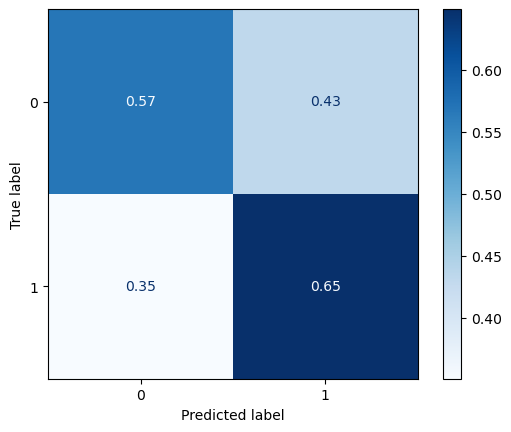

In [210]:
train_accuracy_logreg = accuracy_score(y_train_ovs, logreg.predict(X_train_ovs))

train_fscore_logreg = f1_score(y_train_ovs, logreg.predict(X_train_ovs))

train_recall_logreg = recall_score(y_train_ovs, logreg.predict(X_train_ovs))


print('Training Scores\n')

print('Train Accuracy for Logistic Regression:', np.around(train_accuracy_logreg,2))
print('Train F1 score for Logistic Regression:', np.around(train_fscore_logreg,2))
print('Train Recall for Logistic Regression:', np.around(train_recall_logreg,2))
print('---------------------------------------------------------------------------------------')






accuracy_logreg = accuracy_score(y_test, y_pred_logreg)

fscore_logreg = f1_score(y_test, y_pred_logreg)

recall_logreg = recall_score(y_test, y_pred_logreg)


print('Test Scores\n')

print('Accuracy for Logistic Regression:', np.around(accuracy_logreg,2))
print('F1 score for Logisitic Regression:', np.around(fscore_logreg,2))
print('Recall for Logistic Regression:', np.around(recall_logreg,2))
print('---------------------------------------------------------------------------------------')
print('Classification Report \n')

print(classification_report(y_test, y_pred_logreg))
print('---------------------------------------------------------------------------------------')

plot_confusion_matrix(estimator=logreg, X=X_test, y_true=y_test,normalize='true', cmap='Blues')

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

Training Scores

Train Accuracy for KNN: 0.97
Train F1 score for KNN: 0.97
Train Recall for KNN: 0.98
---------------------------------------------------------------------------------------
Test Scores

Accuracy for KNN: 0.79
F1 score for KNN: 0.21
Recall for KNN: 0.24
---------------------------------------------------------------------------------------
Classification Report 

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      9112
           1       0.18      0.24      0.21      1162

    accuracy                           0.79     10274
   macro avg       0.54      0.55      0.54     10274
weighted avg       0.82      0.79      0.80     10274

---------------------------------------------------------------------------------------


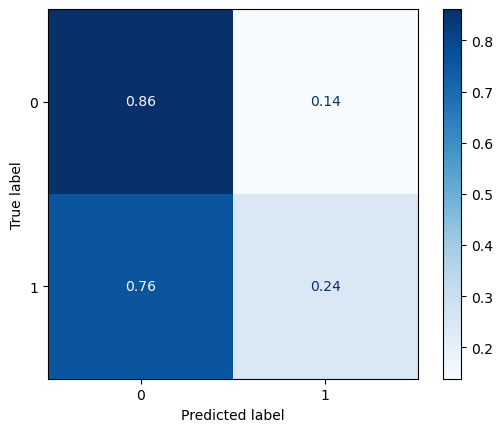

In [211]:
#KNN

start_time=time.time()
knn = KNeighborsClassifier().fit(X_train_ovs, y_train_ovs)
end_time=time.time()

fit_time_knn=end_time-start_time

train_accuracy_knn = accuracy_score(y_train_ovs, knn.predict(X_train_ovs))

train_fscore_knn = f1_score(y_train_ovs, knn.predict(X_train_ovs))

train_recall_knn = recall_score(y_train_ovs, knn.predict(X_train_ovs))

print('Training Scores\n')

print('Train Accuracy for KNN:', np.around(train_accuracy_knn,2))
print('Train F1 score for KNN:', np.around(train_fscore_knn,2))
print('Train Recall for KNN:', np.around(train_recall_knn,2))
print('---------------------------------------------------------------------------------------')


y_pred_knn = knn.predict(X_test)

accuracy_knn = accuracy_score(y_test, y_pred_knn)

fscore_knn = f1_score(y_test, y_pred_knn)

recall_knn = recall_score(y_test, y_pred_knn)

print('Test Scores\n')

print('Accuracy for KNN:', np.around(accuracy_knn,2))
print('F1 score for KNN:', np.around(fscore_knn,2))
print('Recall for KNN:', np.around(recall_knn,2))
print('---------------------------------------------------------------------------------------')
print('Classification Report \n')

print(classification_report(y_test, y_pred_knn))
print('---------------------------------------------------------------------------------------')

plot_confusion_matrix(estimator=knn, X=X_test, y_true=y_test,normalize='true', cmap='Blues')


Training Scores

Train Accuracy for Decision Tree: 1.0
Train F1 score for Decision Tree: 1.0
Train Recall for Decision Tree: 1.0
---------------------------------------------------------------------------------------
Test Scores

Accuracy for Decision Tree: 0.84
F1 score for Decision Tree: 0.06
Recall for Decision Tree: 0.04
---------------------------------------------------------------------------------------
Classification Report 

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      9112
           1       0.08      0.04      0.06      1162

    accuracy                           0.84     10274
   macro avg       0.48      0.49      0.48     10274
weighted avg       0.79      0.84      0.81     10274

---------------------------------------------------------------------------------------


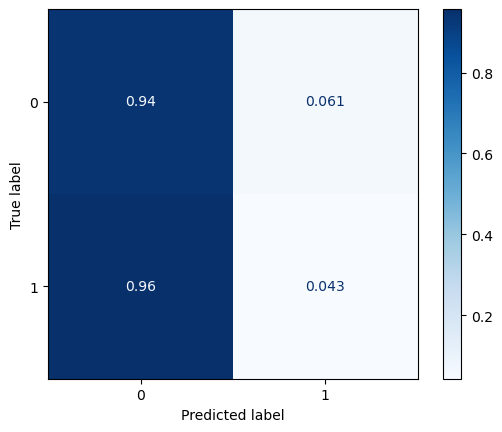

In [257]:
#Decision Tree Classifier

start_time=time.time()
DTC = DecisionTreeClassifier(random_state=0).fit(X_train_ovs, y_train_ovs)
end_time=time.time()

fit_time_DTC = end_time - start_time


train_accuracy_DTC = accuracy_score(y_train_ovs, DTC.predict(X_train_ovs))

train_fscore_DTC = f1_score(y_train_ovs, DTC.predict(X_train_ovs))

train_recall_DTC = recall_score(y_train_ovs, DTC.predict(X_train_ovs))

print('Training Scores\n')

print('Train Accuracy for Decision Tree:', np.around(train_accuracy_DTC,2))
print('Train F1 score for Decision Tree:', np.around(train_fscore_DTC,2))
print('Train Recall for Decision Tree:', np.around(train_recall_DTC,2))
print('---------------------------------------------------------------------------------------')

y_pred_DTC = DTC.predict(X_test)

accuracy_DTC = accuracy_score(y_test, y_pred_DTC)

fscore_DTC = f1_score(y_test, y_pred_DTC)

recall_DTC = recall_score(y_test, y_pred_DTC)


print('Test Scores\n')
print('Accuracy for Decision Tree:', np.around(accuracy_DTC,2))
print('F1 score for Decision Tree:', np.around(fscore_DTC,2))
print('Recall for Decision Tree:', np.around(recall_DTC,2))
print('---------------------------------------------------------------------------------------')
print('Classification Report \n')

print(classification_report(y_test, y_pred_DTC))
print('---------------------------------------------------------------------------------------')

plot_confusion_matrix(estimator=DTC, X=X_test, y_true=y_test,normalize='true', cmap='Blues')


Training Scores

Train Accuracy for SVM: 0.65
Train F1 score for SVM: 0.66
Train Recall for SVM: 0.68
---------------------------------------------------------------------------------------
Test Scores

Accuracy for SVM: 0.6
F1 score for SVM: 0.26
Recall for SVM: 0.61
---------------------------------------------------------------------------------------
Classification Report 

              precision    recall  f1-score   support

           0       0.92      0.60      0.73      9112
           1       0.16      0.61      0.26      1162

    accuracy                           0.60     10274
   macro avg       0.54      0.61      0.49     10274
weighted avg       0.84      0.60      0.68     10274

---------------------------------------------------------------------------------------


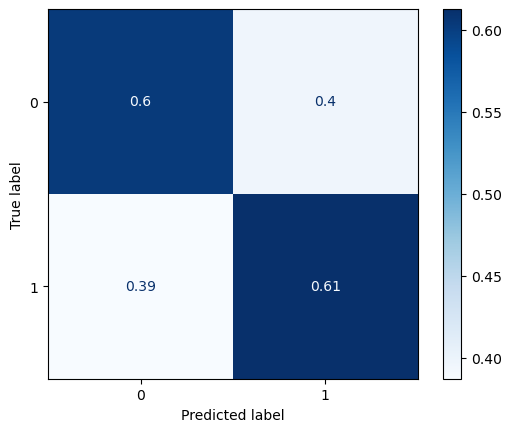

In [220]:
#SVM Classifier

start_time=time.time()
svc = SVC(random_state=0).fit(X_train_ovs, y_train_ovs)
end_time=time.time()

fit_time_SVC = end_time - start_time


train_accuracy_SVC = accuracy_score(y_train_ovs, svc.predict(X_train_ovs))

train_fscore_SVC = f1_score(y_train_ovs, svc.predict(X_train_ovs))

train_recall_SVC = recall_score(y_train_ovs, svc.predict(X_train_ovs))

print('Training Scores\n')

print('Train Accuracy for SVM:', np.around(train_accuracy_SVC,2))
print('Train F1 score for SVM:', np.around(train_fscore_SVC,2))
print('Train Recall for SVM:', np.around(train_recall_SVC,2))
print('---------------------------------------------------------------------------------------')

y_pred_SVC = svc.predict(X_test)

accuracy_SVC = accuracy_score(y_test, y_pred_SVC)

fscore_SVC = f1_score(y_test, y_pred_SVC)

recall_SVC = recall_score(y_test, y_pred_SVC)


print('Test Scores\n')
print('Accuracy for SVM:', np.around(accuracy_SVC,2))
print('F1 score for SVM:', np.around(fscore_SVC,2))
print('Recall for SVM:', np.around(recall_SVC,2))
print('---------------------------------------------------------------------------------------')
print('Classification Report \n')

print(classification_report(y_test, y_pred_SVC))
print('---------------------------------------------------------------------------------------')

plot_confusion_matrix(estimator=svc, X=X_test, y_true=y_test,normalize='true', cmap='Blues')


In [221]:
res_dict = {'Model': ['Dummy','Logistic Regression', 'KNeighbors', 'Decision Tree', 'SVM'],
           'Train Time': [fit_time_dummy, fit_time_logreg, fit_time_knn, fit_time_DTC, fit_time_SVC],
           'Train Accuracy': [train_accuracy_dummy, train_accuracy_logreg, train_accuracy_knn, train_accuracy_DTC, train_accuracy_SVC],
           'Test Accuracy': [accuracy_dummy, accuracy_logreg, accuracy_knn, accuracy_DTC, accuracy_SVC]}
results_df = pd.DataFrame(res_dict)
results_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,Dummy,0.004997,0.500000,0.886899
1,Logistic Regression,0.079321,0.608528,0.577380
2,KNeighbors,0.144892,0.969039,0.791221
3,Decision Tree,0.081826,1.000000,0.837648
4,SVM,329.568717,0.650090,0.604341


All the models have test accuracies that are less than the test accuracy of a dummy classifier. However, given the imbalance in the data, and the need to identify the minority 'subscriber' class, accuracy is not the relevant metric for this application. We want a metric that's sensitive to picking up the small number of subscribers and hence sensitivity (or recall of the minority class) is a better metric for this application. Let's take a look at how the recall scores compare for these models

In [222]:
res_dict_recall = {'Model': ['Dummy','Logistic Regression', 'KNeighbors', 'Decision Tree', 'SVM'],
           'Train Time': [fit_time_dummy, fit_time_logreg, fit_time_knn, fit_time_DTC, fit_time_SVC],
           'Train Recall': [train_recall_dummy, train_recall_logreg, train_recall_knn, train_recall_DTC, train_recall_SVC],
           'Test Recall': [recall_dummy, recall_logreg, recall_knn, recall_DTC, recall_SVC]}
results_recall_df = pd.DataFrame(res_dict_recall)
results_recall_df

,Model,Train Time,Train Recall,Test Recall
0,Dummy,0.004997,0.000000,0.000000
1,Logistic Regression,0.079321,0.654056,0.648881
2,KNeighbors,0.144892,0.978141,0.242685
3,Decision Tree,0.081826,1.000000,0.043029
4,SVM,329.568717,0.680228,0.612737


Here the models esp Logistic Regression seem to be doing a much better job, with a test recall score well above the other classifiers. Also in comparison to the dummy classifier which has a test recall score of 0, the logistic regression classifier has a test recall of 0.65 which looks considerably better.

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

#### Hyperparameter Tuning and Grid Search

We write a user defined function that can accept the classifier model (clf), train and test data, parameter grid relevant to the classifier and a performance metric to be used as a scoring criterion for GridSearchCV. The function returns the results of GridSearchCV including the grid object with the fitted classifier and the average fit time. It also prints out the classification report for the classifier based on the test data evaluation. In this particular problem we are trying to find the small number of subscribers. It's important for the classifier to maximize the sensitvity to this class because term deposits are important source of income for the bank and the bank, in conducting its marketing campaign, should not miss out on too many customers who could be potential term subscribers. Hence for this problem, the appropriate performance metric is **sensitivity or recall of the minority (subscriber) class**.

In [213]:
def eval_grid_clf(clf, X_train, y_train, X_test, y_test, params, scoring):
    grid_clf = GridSearchCV(clf, param_grid=params, scoring = scoring)
    grid_clf.fit(X_train, y_train)
    print(classification_report(y_test, grid_clf.predict(X_test)))
    return grid_clf, np.mean(grid_clf.cv_results_['mean_fit_time'])

##### GridSearchCV for Logistic Regression

In [214]:
#evaluate grid search for Logistic Regression clf
logreg_params = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['lbfgs', 'liblinear'],
}

logreg_grid, logreg_fit_times = eval_grid_clf(LogisticRegression(max_iter=1000, random_state=0), X_train_ovs, y_train_ovs, X_test, y_test, logreg_params, 'recall')

              precision    recall  f1-score   support

           0       0.94      0.45      0.61      9112
           1       0.15      0.76      0.25      1162

    accuracy                           0.49     10274
   macro avg       0.54      0.60      0.43     10274
weighted avg       0.85      0.49      0.57     10274



C:\Users\subha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\subha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\subha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\subha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Val

<AxesSubplot:>

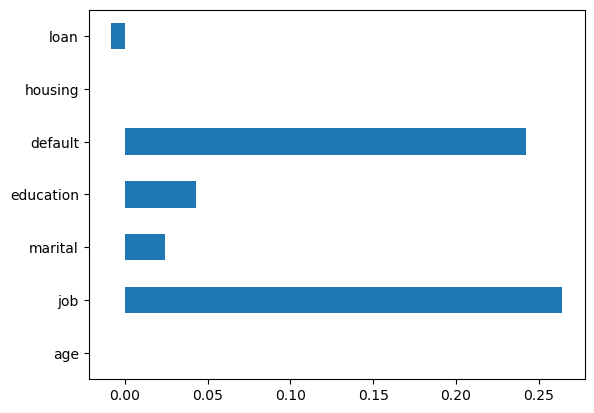

In [313]:
#interpreting logistic regression model
importance = logreg_grid.best_estimator_.coef_[0]

# plot feature importance
pd.Series(importance, index=X.columns).plot(kind='barh') 

The top four features based on Logistic Regression model coefficients seems to be job, default, education and marital status. Age and housing do not have much impact on the model. This ties in nicely with our initial exploratory data analysis which seemed to indicate that age was not a differentiating feature between subscribers and non-subscribers and those who responded 'Yes' to the housing question had roughly the same count of term subscribers versus those who responded 'No'. The top 4 variables based on Logistic Regression coefficents, job, default, education and  marital all showed substantial influence on decision to subscribe in our initial exploratory analysis

##### Feature Selection for Logistic Regression : building a model with top 4 features

In [217]:
#reduced feature with  top 4 feature set for logistic regression
X_4 = df[['default', 'job', 'education', 'marital']]

#train test split
X_tr_4, X_te_4, y_train_4, y_test_4 = train_test_split(X_4, y, random_state = 42)

#Encode categorical features using Leave One out Encoding: The Encoding for test data is done without using test values of target variable
encoder = ce.LeaveOneOutEncoder(return_df=True)

#X_train is the training dataset after leave one out encoder has been applied to categorical features
X_train_4 = encoder.fit_transform(X_tr_4, y_train_4)

# the test set is encoded without utilizing values of y_test
X_test_4 = encoder.transform(X_te_4)

#Scale
X_train_4=StandardScaler().fit_transform(X_train_4)
X_test_4 = StandardScaler().fit_transform(X_test_4)

sm = SMOTE(random_state = 2)
X_train_ovs_4, y_train_ovs_4 = sm.fit_resample(X_train_4, y_train_4.ravel())


logreg_grid_4, logreg_fit_times_4 = eval_grid_clf(LogisticRegression(max_iter=1000, random_state=0), X_train_ovs_4, y_train_ovs_4, X_test_4, y_test_4, logreg_params, 'recall')

              precision    recall  f1-score   support

           0       0.94      0.45      0.61      9112
           1       0.15      0.76      0.25      1162

    accuracy                           0.49     10274
   macro avg       0.54      0.60      0.43     10274
weighted avg       0.85      0.49      0.57     10274



C:\Users\subha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\subha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\subha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\subha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Val

##### Grid Search CV for Decision Tree

In [218]:
# Decision Tree with Grid Search
tree_params = {'max_depth': list(range(1, 11)),
         'min_samples_split': [2, 4, 6, 8],
          'criterion': ['gini', 'entropy'],
          'min_samples_leaf': [0.01, 0.05, 0.1, 0.15, 0.2]
         }
tree_grid, tree_fit_times = eval_grid_clf(DecisionTreeClassifier(random_state=0), X_train_ovs, y_train_ovs, X_test, y_test, tree_params, 'recall')

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      9112
           1       0.10      0.15      0.12      1162

    accuracy                           0.76     10274
   macro avg       0.49      0.49      0.49     10274
weighted avg       0.80      0.76      0.77     10274



##### GridSearchCV for KNeighbors

In [219]:
knn_params = {'n_neighbors': list(range(1, 21, 2))}
knn_grid, knn_fit_times = eval_grid_clf(KNeighborsClassifier(), X_train_ovs, y_train_ovs, X_test, y_test, knn_params, 'recall')

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      9112
           1       0.19      0.21      0.20      1162

    accuracy                           0.81     10274
   macro avg       0.54      0.55      0.54     10274
weighted avg       0.82      0.81      0.81     10274



##### GridSearchCV for SVM Classifier

In [223]:
svc_params = {'kernel': ['rbf', 'poly', 'linear', 'sigmoid']}
svc = SVC(random_state=0).fit(X_train_ovs, y_train_ovs)

svc_grid, svc_fit_times = eval_grid_clf(svc, X_train_ovs, y_train_ovs, X_test, y_test, svc_params, 'recall')


              precision    recall  f1-score   support

           0       0.92      0.60      0.73      9112
           1       0.16      0.61      0.26      1162

    accuracy                           0.60     10274
   macro avg       0.54      0.61      0.49     10274
weighted avg       0.84      0.60      0.68     10274



In [232]:
svc_fit_times

180.0040227293968

In [233]:
#svc with probability set to True: this is done to get the probabilities for plotting ROC but is separately run as fit times are typically longer with probability=True

svc_params = {'kernel': ['rbf', 'poly', 'linear', 'sigmoid']}
svc_true = SVC(random_state=0, probability=True).fit(X_train_ovs, y_train_ovs)

svc_grid_true, svc_fit_times_true = eval_grid_clf(svc_true, X_train_ovs, y_train_ovs, X_test, y_test, svc_params, 'recall')

              precision    recall  f1-score   support

           0       0.92      0.60      0.73      9112
           1       0.16      0.61      0.26      1162

    accuracy                           0.60     10274
   macro avg       0.54      0.61      0.49     10274
weighted avg       0.84      0.60      0.68     10274



##### ROC Analysis and Area Under Curve for Different Models

Text(0.5, 1.0, 'Comparing ROC curves for different classifiers')

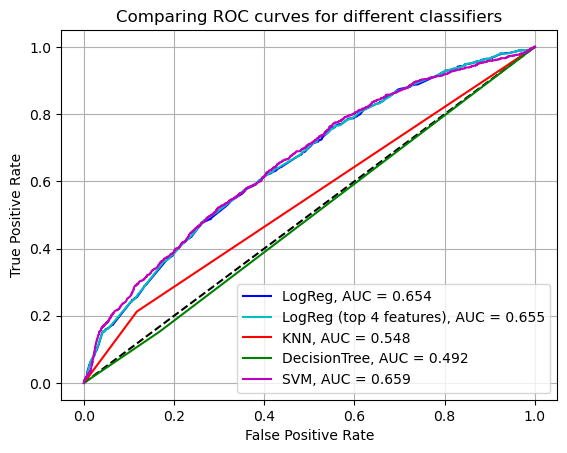

In [250]:
#compare ROC curves for different models

plt.plot([0, 1], [0, 1],'k--')
#preds_proba_logreg_grid = logreg_grid.best_estimator_.predict_proba(X_test)
#probs_logreg_grid = preds_proba_logreg_grid[:, 1]
fpr_logreg, tpr_logreg, thresh_logreg = roc_curve(y_test, logreg_grid.best_estimator_.predict_proba(X_test)[:,1])
fpr_logreg_4, tpr_logreg_4, thresh_logreg_4 = roc_curve(y_test_4, logreg_grid_4.best_estimator_.predict_proba(X_test_4)[:,1])

fpr_knn, tpr_knn, thresh_knn = roc_curve(y_test, knn_grid.best_estimator_.predict_proba(X_test)[:,1])
fpr_DTC, tpr_DTC, thresh_DTC = roc_curve(y_test, tree_grid.best_estimator_.predict_proba(X_test)[:,1])
fpr_SVC, tpr_SVC, thresh_SVC = roc_curve(y_test, svc_grid_true.best_estimator_.predict_proba(X_test)[:,1])


auclogreg = roc_auc_score(y_test,logreg_grid.best_estimator_.predict_proba(X_test)[:,1] )
auclogreg_4 = roc_auc_score(y_test_4,logreg_grid_4.best_estimator_.predict_proba(X_test_4)[:,1] )

aucknn = roc_auc_score(y_test,knn_grid.best_estimator_.predict_proba(X_test)[:,1] )
aucDTC = roc_auc_score(y_test,tree_grid.best_estimator_.predict_proba(X_test)[:,1] )
aucSVC = roc_auc_score(y_test,svc_grid_true.best_estimator_.predict_proba(X_test)[:,1] )


plt.plot(fpr_logreg, tpr_logreg,'b', label=f'LogReg, AUC = {str(round(auclogreg,3))}')
plt.plot(fpr_logreg_4, tpr_logreg_4,'c', label=f'LogReg (top 4 features), AUC = {str(round(auclogreg_4,3))}')

plt.plot(fpr_knn, tpr_knn,'r', label=f'KNN, AUC = {str(round(aucknn,3))}')
plt.plot(fpr_DTC, tpr_DTC,'g', label=f'DecisionTree, AUC = {str(round(aucDTC,3))}')
plt.plot(fpr_SVC, tpr_SVC,'m', label=f'SVM, AUC = {str(round(aucSVC,3))}')



plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('Comparing ROC curves for different classifiers')

##### Summary of Results After HyperParameter Tuning for Different Models

In [254]:
#summary of results after hyperparameter optimization with GridSearchCV for different models

pd.set_option('max_colwidth', None)


results_Grid = {'Models': [ 'Logistic Regression', 'Logistic Regression (top 4 features)', 'KNeighbors', 'Decision Tree', 'SVC'],
           
           'Test Recall': [0.76, 0.76, 0.21, 0.15, 0.61],
            
            'ROC AUC' : [0.654, 0.655, 0.548, 0.492, 0.659],
           
            'Best params ':[logreg_grid.best_params_, logreg_grid_4.best_params_,  knn_grid.best_params_, tree_grid.best_params_, svc_grid.best_params_],
            
       
           'Average fit time' : [logreg_fit_times, logreg_fit_times_4,  knn_fit_times, tree_fit_times, svc_fit_times]
                   
                   }

df_results_Grid = pd.DataFrame(results_Grid)
df_results_Grid

,Models,Test Recall,ROC AUC,Best params,Average fit time
0,Logistic Regression,0.76,0.654,"{'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}",0.048436
1,Logistic Regression (top 4 features),0.76,0.655,"{'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}",0.031340
2,KNeighbors,0.21,0.548,{'n_neighbors': 1},0.115515
3,Decision Tree,0.15,0.492,"{'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 0.01, 'min_samples_split': 2}",0.038170
4,SVC,0.61,0.659,{'kernel': 'rbf'},180.004023


#### Best Model

The best model from the perspective of minimal number of features, shortest average fit time and the best (sensitivity) recall score for the subscriber class is **Logistic Regression classifier which is based on the top four impactful features, namely job, default, education and marital (in order of importance)**. Logistic Regression with this reduced feature set has similar (or slightly better, in terms of ROC AUC) performance as the Logistic Regression model incorporating all seven features from the bank client data.

Support Vector Machine (SVM)-based classifier is next best which closely matches the performance of Logistic Regression but has the longest fit time, with its average fit time several orders of magnitude higher than Logistic Regression.

KNeighbors (KNN) and Decision Tree classifiers did not work well for this classification problem as reflected by low recall (sensitivity) for the subscriber class and an ROC AUC that's roughly around 0.5 (a random classifier would have an expected ROC AUC of 0.5)

#### Cumulative Gains Curve for Logistic Regression and SVM Classifiers

In [ ]:
pip install scikit-plot

In [241]:
import scikitplot as skplt


Text(0.5, 1.0, 'Cumulative Gains Curve for Logistic Regression (Top 4 Features)')

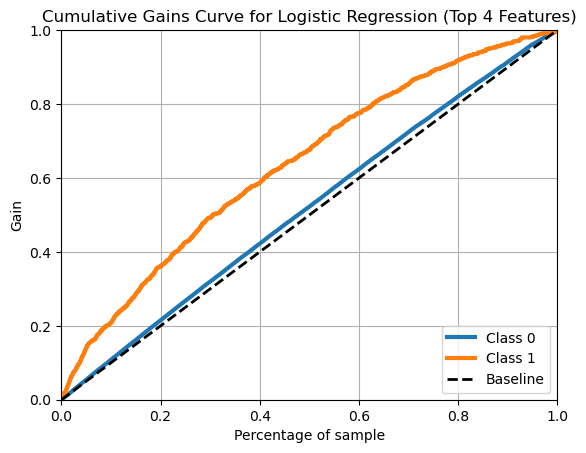

In [284]:
skplt.metrics.plot_cumulative_gain(y_true=y_test_4, y_probas=logreg_grid_4.best_estimator_.predict_proba(X_test_4))
plt.title('Cumulative Gains Curve for Logistic Regression (Top 4 Features)')


Text(0.5, 1.0, 'Cumulative Gains Curve for SVM')

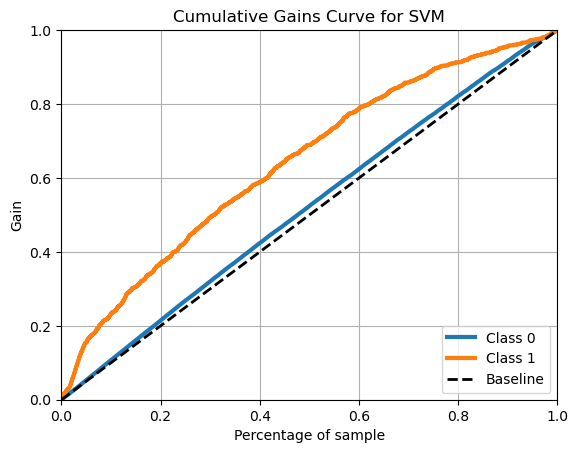

In [247]:
skplt.metrics.plot_cumulative_gain(y_true=y_test, y_probas=svc_grid_true.best_estimator_.predict_proba(X_test))
plt.title('Cumulative Gains Curve for SVM')



The cumulative gains curve are similar for the top two models, Logistic Regression and SVM. The curve shows that  for a  given sampling percentage (<100%) of clients, the model is going to net more subscribers than just random sampling. For example, using the model, by sampling just 60% of the bank clients, it is possible to get about 80% of the term subscribers - a gain of 20% points over randomly sampling 60%

##### Questions

Is it possible to improve the performance of the Logistic Regression model using other data from csv file?

We start by looking at the correlation matrix to see if there are other uncorrelated features 

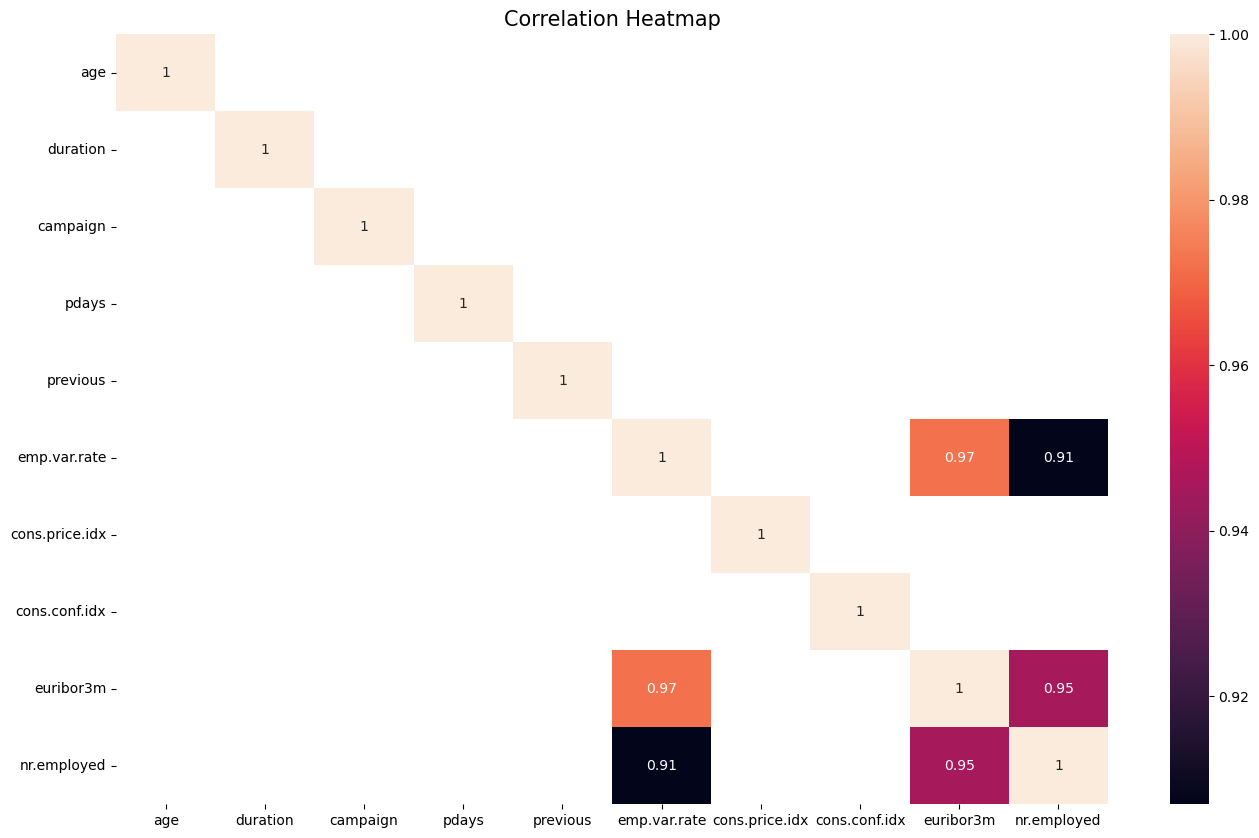

In [310]:
corr_matrix = df.corr()
# plotting the heatmap of only highly correlated varibles with threshold value 0.9
plt.figure(figsize=(16,10))
sns.heatmap(corr_matrix[corr_matrix > 0.9], annot=True)
plt.title("Correlation Heatmap",  fontsize = 15)
plt.show()

We know that duration of the call should not be included as a feature for a realistic predictor as it is known only after the call has been made. However, there are other information related to month of the call, contact type, outcomes from previous campaigns and prevailing social and economic context attributes which seem to have a substantial impact on decision to subscribe based on our initial exploratory data analysis.Hence, incorporating these features may help improve the performance of the model. This may be useful information to know as well for future campaigns. For example, if there are particular months when customers are more likely to subscribe that's helpful to know. If there are certain prevailing economic/social context attributes that impacts term subscription that's important to know. If the client's response to previous campaigns are known, that may be useful information going forward.  These features may add more valuable information for future campaigns on top of the basic client related data that our models have used this far.

Hence we add the following features to our Logistic Regression model to see if they can enhance the performance over the model that used just the  basic client info.


Information that may affect subscription, e.g. contact type, month of contact, outcomes from previous campaigns 

**contact**: contact communication type (categorical: 'cellular','telephone')

**month**: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

**poutcome**: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')



Information on prevailing social/economic conditions: these are not related to the client but may affect client's subscription

**cons.price.idx**: consumer price index - monthly indicator (numeric)

**cons.conf.idx**: consumer confidence index - monthly indicator (numeric)

**euribor3m**: euribor 3 month rate - daily indicator (numeric)


It is to be noted that emp.var.rate and nr.employed have strong correlation wit euribor3m, so only one of these, euribor3m, is retained for the model as strongly correlated features would lead to multi-collinearity which is not ideal for Logistic Regression

In [312]:
X_add_feat = df[['default', 'job', 'education', 'marital', 'contact', 'month' , 'poutcome', 'cons.price.idx','cons.conf.idx', 'euribor3m']]

#train test split
X_tr_add_feat, X_te_add_feat, y_train_add_feat, y_test_add_feat = train_test_split(X_add_feat, y, random_state = 42)

#Encode categorical features using Leave One out Encoding: The Encoding for test data is done without using test values of target variable
encoder = ce.LeaveOneOutEncoder(return_df=True)

#X_train is the training dataset after leave one out encoder has been applied to categorical features
X_train_add_feat = encoder.fit_transform(X_tr_add_feat, y_train_add_feat)

# the test set is encoded without utilizing values of y_test
X_test_add_feat = encoder.transform(X_te_add_feat)

#Scale
X_train_add_feat=StandardScaler().fit_transform(X_train_add_feat)
X_test_add_feat = StandardScaler().fit_transform(X_test_add_feat)

sm = SMOTE(random_state = 2)
X_train_ovs_add_feat, y_train_ovs_add_feat = sm.fit_resample(X_train_add_feat, y_train_add_feat.ravel())


logreg_grid_add_feat, logreg_fit_times_add_feat = eval_grid_clf(LogisticRegression(max_iter=1000, random_state=0), X_train_ovs_add_feat, y_train_ovs_add_feat, X_test_add_feat, y_test_add_feat, logreg_params, 'recall')

print('The best Logistic Regression model with the added features:\n' , logreg_grid_add_feat.best_estimator_)

              precision    recall  f1-score   support

           0       0.96      0.72      0.82      9112
           1       0.25      0.74      0.38      1162

    accuracy                           0.72     10274
   macro avg       0.61      0.73      0.60     10274
weighted avg       0.88      0.72      0.77     10274

The best Logistic Regression model with the added features:
 LogisticRegression(C=0.001, max_iter=1000, penalty='l1', random_state=0,
                   solver='liblinear')


C:\Users\subha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 140.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\subha\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\subha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\subha\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Val

The additional features did not improve the subscriber recall score (sensitivity): the subscriber recall score went down a little bit from 0.76 to 0.74. However it did improve the recall for the non-subscriber class (specificity) substantially from 0.45 to 0.72. In the end this may be a better model from the perspective of ROC curve area and Cumulative Gains analysis

Text(0.5, 1.0, 'Comparing ROC curves for Logistic Regression with\n a) Top 4 Client Features (cyan)\n b) Additional Features (orange)')

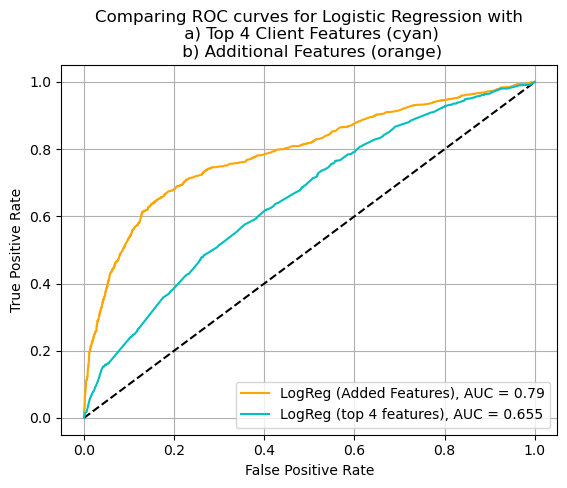

In [308]:
#compare ROC curves for different models

plt.plot([0, 1], [0, 1],'k--')
#preds_proba_logreg_grid = logreg_grid.best_estimator_.predict_proba(X_test)
#probs_logreg_grid = preds_proba_logreg_grid[:, 1]
fpr_logreg_add_feat, tpr_logreg_add_feat, thresh_logreg_add_feat = roc_curve(y_test_add_feat, logreg_grid_add_feat.best_estimator_.predict_proba(X_test_add_feat)[:,1])
fpr_logreg_4, tpr_logreg_4, thresh_logreg_4 = roc_curve(y_test_4, logreg_grid_4.best_estimator_.predict_proba(X_test_4)[:,1])




auclogreg_add_feat = roc_auc_score(y_test_add_feat,logreg_grid_add_feat.best_estimator_.predict_proba(X_test_add_feat)[:,1] )
auclogreg_4 = roc_auc_score(y_test_4,logreg_grid_4.best_estimator_.predict_proba(X_test_4)[:,1] )




plt.plot(fpr_logreg_add_feat, tpr_logreg_add_feat,'orange', label=f'LogReg (Added Features), AUC = {str(round(auclogreg_add_feat,3))}')
plt.plot(fpr_logreg_4, tpr_logreg_4,'c', label=f'LogReg (top 4 features), AUC = {str(round(auclogreg_4,3))}')





plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid()
plt.title('Comparing ROC curves for Logistic Regression with\n a) Top 4 Client Features (cyan)\n b) Additional Features (orange)')

Text(0.5, 1.0, 'Cumulative Gains Curve for Logistic Regression (Additional Features)')

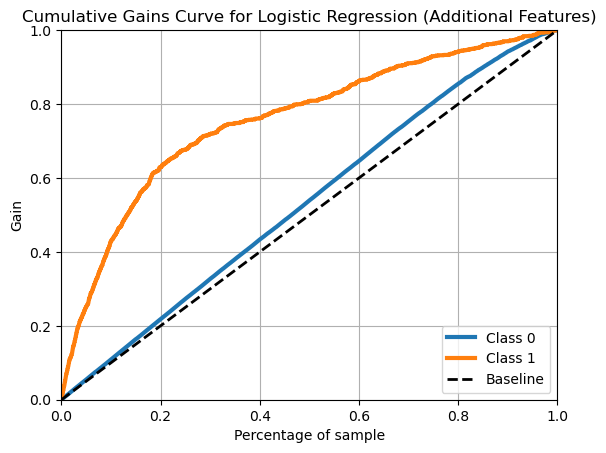

In [309]:
skplt.metrics.plot_cumulative_gain(y_true=y_test_add_feat, y_probas=logreg_grid_add_feat.best_estimator_.predict_proba(X_test_add_feat))
plt.title('Cumulative Gains Curve for Logistic Regression (Additional Features)')

The Logistic Regression model with the additional features has a higher ROC-AUC score (0.79) compared to that with the top four client features (AUC=0.66). There's also an improvement evident from the cumulative gains curve:  over 60% of subscribers can be reached by sampling only 20% of the  clients based on this model. This is a 40% points gain over just randomly sampling 20% of the population which would have expectedly netted only 20% of subscribers. To reach 80% of subscribers, just 50% of the clients need to be sampled based on the model which reflects a gain in subscribers by 30% points compared to just randomly sampling 50%.